# DEMO compression & LFI

This demo loads into memory pseudo-cl measurements from simulations, compresses them using neural networks, then uses LFI to estimate the parameters posterior

# load data

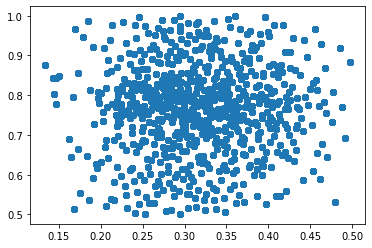

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#load simulated pseudocl into memory
data = np.load('/global/u2/m/mgatti/LFI_desy3/data/demo_compression_LFI_data_cl.npy',allow_pickle=True).item()


#plot the parameter space spanned by the data
plt.scatter(data['params'][:,0],data['params'][:,1])
plt.xlabel('Omega_m')
plt.ylabel('S8')

# compression

In [3]:
import sys
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/project/projectdirs/des/mgatti/tensorflow_115/")
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_probability//")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
#
#
def simple_model_2d_1k(input_size, lr=1e-4):
    # create model
    model = Sequential()
    model.add(Dense(900, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(800, input_dim=input_size, kernel_initializer='normal'))
    model.add(LeakyReLU(alpha=0.01))
    # model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    model.add(Dense(100, input_dim=input_size, kernel_initializer='normal'))
    # model.add(LeakyReLU(alpha=0.01))
    model.add(ReLU())
    # model.add(ReLU())
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(optimizer=Adam(lr=lr), loss='mse')
    return model


In [ ]:
import os

# folder to work on:
output_folder = '/global/cfs/cdirs/des/mgatti/tests/'
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
if not os.path.exists(output_folder+'/compression/'):
    os.mkdir(output_folder+'/compression/')
if not os.path.exists(output_folder+'/compression_models/'):
    os.mkdir(output_folder+'/compression_models/')


# normalise the data
sim_data =  np.clip(0.5+0.2 * (data['final_dv']-np.median(data['final_dv'],axis=0)) / np.std(data['final_dv'], axis=0) ,-0.5,1.5)
par_labels = ['om','S8']

# compress!
for par, label_run in enumerate(par_labels):
    regression_power = simple_model_2d_1k(data['final_dv'].shape[1], lr=1e-5)

    #validation set 
    special_ = np.arange(data['final_dv'].shape[0])<1000
    number_of_iter = 6 # usually after epochs it doesn't improve anymore.

    for i in range(number_of_iter):

        # add some noise to avoid overfitting -----
        numerical_noise = np.random.normal(sim_data*0.,2e-3)
        history_2d_power = regression_power.fit((sim_data+numerical_noise)[~special_],
                           data['params'][~special_,:][:,par],
                           epochs =10,batch_size = 32, shuffle=True,
                           validation_data = ((sim_data)[special_],
                                            data['params'][special_,:][:,par]))


    compressed_data1  = np.clip(regression_power.predict(sim_data), -1., 1.5)


    compressed_des_mock1 = compressed_data1.mean(axis=0)
    results = {'sim_params1':  data['params'], 'compressed_data1':compressed_data1}
    np.save(output_folder+'/compression/'+label_run,results)
    regression_power.save_weights((output_folder+'/compression_models/'+label_run))



In [50]:
# compress a target data vector. Let's use one of the realisations from our sims set!
rel = 130

print('Om :{0:2.2f}, S8: {1:2.2f}'.format(data['params'][rel,0],data['params'][rel,1]))

all_you_need_for_LFI = dict()

#loop over parameters
for par, label_run in enumerate(par_labels):
    dv =  np.clip(0.5+0.2 * (data['final_dv'][rel]-np.median(data['final_dv'],axis=0)) / np.std(data['final_dv'], axis=0) ,-0.5,1.5)
    
    regression_power = simple_model_2d_1k(data['final_dv'].shape[1], lr=1e-5)
    regression_power.load_weights((output_folder+'/compression_models/'+label_run))
    predict = np.clip(regression_power.predict(dv.reshape(1,-1)), -1., 1.5)

    mute = np.load(output_folder+'/compression/'+label_run+'.npy',allow_pickle=True).item()
    
    if par == 0:
        all_you_need_for_LFI['sim_params']  = data['params'][:,par]
        all_you_need_for_LFI['compressed_data_sims']  = mute['compressed_data1']
        all_you_need_for_LFI['target']  = [predict]
    else:
        all_you_need_for_LFI['compressed_data_sims']  = np.hstack([all_you_need_for_LFI['compressed_data_sims'],mute['compressed_data1']])
        all_you_need_for_LFI['sim_params']  = np.vstack([all_you_need_for_LFI['sim_params'],data['params'][:,par]])
        all_you_need_for_LFI['target'].append(predict)
all_you_need_for_LFI['target'] = np.array(all_you_need_for_LFI['target'])[:,0,0]
all_you_need_for_LFI['sim_params'] = all_you_need_for_LFI['sim_params'].T

Om :0.41, S8: 0.71


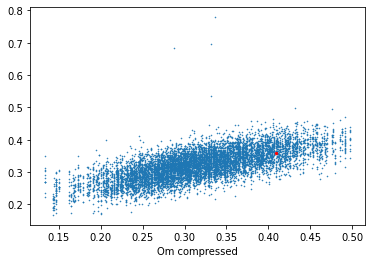

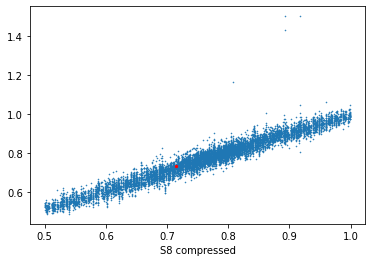

In [59]:
# plot compressed statistics
plt.scatter(all_you_need_for_LFI['sim_params'][:,0],all_you_need_for_LFI['compressed_data_sims'][:,0],s=0.3)
plt.scatter([all_you_need_for_LFI['sim_params'][rel,0]],[all_you_need_for_LFI['target'][0]],s=5.3,color='red')
plt.xlabel('Om sims')
plt.xlabel('Om compressed')
plt.show()

plt.scatter(all_you_need_for_LFI['sim_params'][:,1],all_you_need_for_LFI['compressed_data_sims'][:,1],s=0.3)
plt.scatter([all_you_need_for_LFI['sim_params'][rel,1]],[all_you_need_for_LFI['target'][1]],s=5.3,color='red')
plt.xlabel('S8 sims')
plt.xlabel('S8 compressed')
plt.show()


# LFI code

In [95]:
# run chain with LFI
sys.path.insert(0, "/global/cfs/cdirs/des/mgatti/tensorflow_115/")
import pydelfi.priors as priors
import tensorflow as tf
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import emcee as mc
lower = np.array([0.15, 0.55])
upper = np.array([0.49, 0.9])

theta2d_expected_mean = [0.3, 0.75]
prior = priors.Uniform(lower, upper)

def initial_parameters(theta, relative_sigma):
    """
    This is not randomise the initial position of the
    :param theta: list/a
    rray of parameter values
    :param relative_sigma: controls variance of random draws
    :return: the theta array but with random shifts
    """
    theta = np.array(theta)
    return np.random.normal(theta, np.abs(theta * relative_sigma))

result_dir = '../../../../../../../pscratch/sd/m/mgatti/temp2/'       


count = 0


In [96]:


compressed_data1 = all_you_need_for_LFI['compressed_data_sims'] 
nn = len(lower)
base = count # any time you re-run it, please increase this by the number of NDEs. Otherwise you'd need to restart the notebook.
count += 2
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_data1.shape[1], n_hiddens=[50,50], n_mades=2, act_fun=tf.tanh, index=base + 0),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=nn, n_data=compressed_data1.shape[1], n_hiddens=[50,50], n_mades=3, act_fun=tf.tanh, index=base + 1)]
        #ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 2),
        #ndes.MixtureDensityNetwork(n_parameters=nn, n_data=compressed_data1.shape[1], n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=base + 3)]



pn = ['p{0}'.format(i) for i in range(nn)]


import os
try:
    os.mkdir(result_dir+'/'+str(base))
except:
    pass
try:
    os.system('rm '+result_dir+'/'+str(base)+'/*')
except:
    pass

DelfiEnsemble = delfi.Delfi(np.array(np.median(compressed_data1,axis=0), dtype = 'float'), prior, NDEs,
                                    param_limits = [lower, upper],
                                    param_names = pn, 
                                    results_dir = result_dir+'/'+str(base)+'/')
#,False,False]

DelfiEnsemble.load_simulations(np.array(compressed_data1[:,:], dtype = 'float'), all_you_need_for_LFI['sim_params'])
DelfiEnsemble.train_ndes()



n_dim2d=nn
n_burn2d=100
n_steps2d = 10000
n_walkers2d = nn * n_dim2d



theta0_2d = np.array([list(initial_parameters(theta2d_expected_mean, 0.01)) for i in range(n_walkers2d)])




def prior_term2d(theta2d):
    p_ = theta2d.T
    for i in range(len(p_)):
        if ((p_[i]<lower[i])|(p_[i]>upper[i])):
            return  - np.inf
    return  0.



def log_posterior2d_temp(theta2d, data):
    return DelfiEnsemble.log_posterior_stacked([theta2d.T],data=data)[0][0] + prior_term2d(theta2d)


sampler2d_ = mc.EnsembleSampler(n_walkers2d, n_dim2d, log_posterior2d_temp,args=(all_you_need_for_LFI['target'],))

_ = sampler2d_.run_mcmc(theta0_2d, n_burn2d+n_steps2d)

final_chain = sampler2d_.get_chain()


Training:   9%|▉         | 45/500 [00:22<01:07,  6.74it/s, train loss=0.902, val loss=0.95] 

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//10/graph_checkpoint


INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//10/graph_checkpoint
Training:  16%|█▌        | 78/500 [00:37<01:22,  5.10it/s, train loss=0.893, val loss=0.913]

INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//10/graph_checkpoint


INFO:tensorflow:Restoring parameters from ../../../../../../../pscratch/sd/m/mgatti/temp2//10/graph_checkpoint
Training:  16%|█▌        | 78/500 [00:38<03:30,  2.00it/s, train loss=0.893, val loss=0.913]


Removed no burn in


<Figure size 288x288 with 0 Axes>

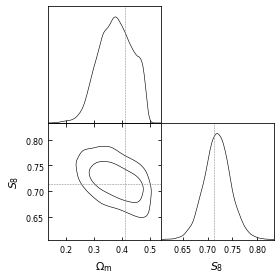

In [97]:

import getdist
from getdist import plots, MCSamples


samples = MCSamples(samples=[final_chain[:,:,0].flatten(),final_chain[:,:,1].flatten()],
                    names = ['Om','s8'],labels = [r'\Omega_{\rm m}',r'S_8'],
                    label='chain',
                   settings={'mult_bias_correction_order':1,'smooth_scale_2D':0.4, 'smooth_scale_1D':0.2})



plt.figure(figsize=(4,4))
g = plots.get_subplot_plotter()
#g.triangle_plot([samples4_c,ss],['Om','s8'],label = ['all','cl'] ,shaded=True)

g.triangle_plot([samples],['Om','s8'],legend_loc='upper right' ,markers = all_you_need_for_LFI['sim_params'][rel,:]) #,shaded=True)




# compute p-values

In [100]:
from scipy.optimize import minimize,differential_evolution
import copy
def log_like_temp(theta2d, data):
    return -(DelfiEnsemble.log_posterior_stacked([theta2d.T],data=data)[0][0])

bounds = [(lower[0], upper[0]), (lower[1], upper[1])]
store = []
for i__ in range(1000):
    i__i = np.random.randint(0,len(compressed_data1),1)[0]
    target_dv1  = copy.deepcopy(compressed_data1[i__i,:])

    # Define the bounds for each parameter (if needed)
    # Perform the optimization
    rslt = differential_evolution(log_like_temp, bounds=bounds,  maxiter=100,args=(target_dv1,))
    # Retrieve the optimized parameters
    optimized_params = rslt.x
    store.append(log_like_temp(optimized_params, target_dv1)) 

# do it for the data
rslt = differential_evolution(log_like_temp, bounds=bounds, , maxiter=100,args=(all_you_need_for_LFI['target'],))
optimized_params = rslt.x
data_loglike = (log_like_temp(optimized_params, all_you_need_for_LFI['target'])) 
  

/global/homes/m/mgatti/.conda/envs/bfd_env3/lib/python3.6/site-packages/pydelfi/delfi.py:222: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


p-value = 0.665


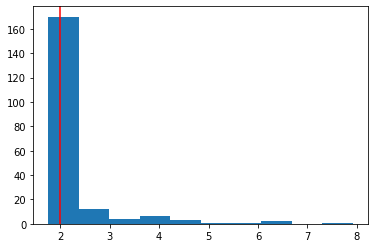

In [107]:
plt.hist(store)
plt.axvline(x=data_loglike,color='red')
store = np.array(store)
print ('p-value = {0:2.3f}'.format(len(store[store>data_loglike])/len(store)))
